In [21]:
from pathlib import Path

import kagglehub
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from xgboost import XGBRegressor, XGBRFRegressor

In [22]:
full_results = pd.DataFrame()

Download the supplementary data from Kaggle for artist info

In [23]:
if Path("data/spotify_artist_data.csv").exists():
    artist_stats = pd.read_csv("data/spotify_artist_data.csv")
else:
    path = kagglehub.dataset_download("adnananam/spotify-artist-stats")
    artist_stats = pd.read_csv(path + "/spotify_artist_data.csv", index_col=0)

    # Remove error rows b/c the creator didn't process correctly
    artist_stats = artist_stats[artist_stats["Lead Streams"] != "Lead Streams"]

    # Cast numeric columns to int
    for col in ["Lead Streams", "Feats", "Tracks", "One Billion", "100 Million"]:
        artist_stats[col] = artist_stats[col].str.replace(",", "").astype(int)

    # Remove the last updated column, it's not useful/relevant
    artist_stats = artist_stats.drop(columns=["Last Updated"])

    artist_stats.to_csv("data/spotify_artist_data.csv", index=False)

artist_stats.head()

,Artist Name,Lead Streams,Feats,Tracks,One Billion,100 Million
0,Drake,50162292808,19246513666,262,6,130
1,Bad Bunny,44369032140,5391990975,163,5,118
2,Ed Sheeran,38153682361,2791278201,240,10,62
3,The Weeknd,34767779741,4288903657,186,8,72
4,Taylor Swift,32596728109,424053296,323,1,96


Download the dataset from HuggingFace using Pandas, and drop the extra index column. The `na`/`NaN` values were dropped from the `artists` column because that column is used to merge the supplementary data above with the main dataset.

In [24]:
# Pulled dataset from HF, dropped unneeded index column
if Path("data/spotify_tracks.csv").exists():
    df = pd.read_csv("data/spotify_tracks.csv")
else:
    df = (
        pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
        .drop("Unnamed: 0", axis=1)
        .dropna(subset=["artists"])
    )

    df["duration_s"] = df["duration_ms"] / 1000
    df = df.drop(columns=["duration_ms"])  # Drop original duration column, keep seconds

    df.to_csv("data/spotify_tracks.csv", index=False)

df_nodupe = df.drop_duplicates(subset=["track_id"]).copy()

df.head()

,track_id,artists,album_name,track_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration_s
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,230.666
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,149.610
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,210.826
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,201.933
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,198.853


Adding in more information to the main dataset using each artist's stats. If there are two or more artists present, the stats are averaged.

Stats merged:

- Lead streams
- Streams of features
- Number of tracks
- Number of songs with more than one billion streams
- Number of songs with more than 100 million streams

In [25]:
if not Path("data/spotify_tracks_processed.csv").exists():
    art_stats_name = set(artist_stats["Artist Name"].values)
    lead_streams, feats, tracks, one_billion, hundred_million = [], [], [], [], []

    for row in tqdm(df_nodupe.iterrows(), total=df_nodupe.shape[0], desc="Processing rows"):
        artists = [x.strip() for x in row[1]["artists"].split(";")]
        temp_lead_streams, temp_feats, temp_tracks, temp_one_billion, temp_hundred_million = (
            [],
            [],
            [],
            [],
            [],
        )

        for artist in artists:
            if artist in art_stats_name:
                temp_lead_streams.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["Lead Streams"].values[0]
                )
                temp_feats.append(artist_stats[artist_stats["Artist Name"] == artist]["Feats"].values[0])
                temp_tracks.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["Tracks"].values[0]
                )
                temp_one_billion.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["One Billion"].values[0]
                )
                temp_hundred_million.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["100 Million"].values[0]
                )

        for col, temp in zip(
            [lead_streams, feats, tracks, one_billion, hundred_million],
            [temp_lead_streams, temp_feats, temp_tracks, temp_one_billion, temp_hundred_million],
            strict=True,
        ):
            if len(temp) > 0:
                col.append(np.mean(temp))
            else:
                col.append(0)

    df_nodupe["lead_streams"] = lead_streams
    df_nodupe["feats"] = feats
    df_nodupe["tracks"] = tracks
    df_nodupe["one_billion"] = one_billion
    df_nodupe["hundred_million"] = hundred_million

    g_dummy = pd.get_dummies(df["track_genre"]).groupby(df["track_id"]).sum().astype(int).reset_index()

    dummy_val = g_dummy.copy()
    dummy_val["total"] = dummy_val.sum(axis=1, numeric_only=True)
    dummy_val = dummy_val[["track_id", "total"]].sort_values("track_id", ascending=True)

    process_check = (
        df.groupby("track_id")
        .size()
        .to_frame("total")
        .reset_index()
        .sort_values("track_id", ascending=True)
    )

    for df1, df2 in zip(process_check.iterrows(), dummy_val.iterrows(), strict=True):
        assert (df1[1]["total"] == df2[1]["total"]) and (df1[1]["track_id"] == df2[1]["track_id"])

    df = df_nodupe.merge(g_dummy, on="track_id").drop(
        ["track_id", "artists", "album_name", "track_name", "track_genre"], axis=1
    )
    df["explicit"] = df["explicit"].astype(int)
    df.to_csv("data/spotify_tracks_processed.csv", index=False)

else:
    df = pd.read_csv("data/spotify_tracks_processed.csv")

In [26]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[
    df.columns.difference(
        ["popularity", "lead_streams", "feats", "tracks", "one_billion", "hundred_million"]
    )
]
y = df["popularity"]

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the LinearRegression model
model = LinearRegression(
    n_jobs=-1,
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": ["Baseline Linear Regression"],
                "R²": [r2],
                "MSE": [mse],
                "RMSE": [rmse],
                "MAE": [mae],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R²: 0.3491801608462217
MSE: 273.8976243937096
RMSE: 16.549852700060796
MAE: 11.890187841790453


In [27]:
df.describe()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,spanish,study,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
count,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,...,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,33.198808,0.085848,0.562166,0.634458,5.283530,-8.498994,0.636973,0.087442,0.328285,0.173415,...,0.011143,0.011143,0.011143,0.011143,0.011143,0.011143,0.011143,0.011143,0.011143,0.011143
std,20.580640,0.280141,0.176692,0.256606,3.559912,5.221518,0.480875,0.113278,0.338321,0.323849,...,0.104973,0.105185,0.104973,0.104973,0.104973,0.104973,0.105079,0.105291,0.105079,0.105079
min,0.000000,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.450000,0.457000,2.000000,-10.322250,0.000000,0.036000,0.017100,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,0.576000,0.676000,5.000000,-7.185000,1.000000,0.048900,0.188000,0.000058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,0.000000,0.692000,0.853000,8.000000,-5.108000,1.000000,0.085900,0.625000,0.097625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000


In [28]:
df.corr()["popularity"].sort_values(ascending=False)

popularity          1.000000
pop-film            0.134407
k-pop               0.122339
hundred_million     0.106079
chill               0.105386
                      ...   
detroit-techno     -0.113376
latin              -0.127165
instrumentalness   -0.127477
romance            -0.141027
iranian            -0.157936
Name: popularity, Length: 134, dtype: float64

### Backfill missing `lead_streams` values

In [29]:
# Create mask for rows where lead_streams is 0
mask = df['lead_streams'] == 0

# Split data into features (X) and target (y)
X_train = df[~mask].drop(['lead_streams', 'popularity'], axis=1)
y_train = df[~mask]['lead_streams']

# Prepare features for prediction
X_pred = df[mask].drop(['lead_streams', 'popularity'], axis=1)

# Initialize and train the RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1, 
    max_features='sqrt',
    verbose=1
)
rf_model.fit(X_train, y_train)

# Make predictions for empty values
predictions = rf_model.predict(X_pred)

# Fill in the empty values
df.loc[mask, 'lead_streams'] = predictions

# Verify no more zeros in lead_streams
print(f"Number of zeros in lead_streams: {(df['lead_streams'] == 0).sum()}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Number of zeros in lead_streams: 0


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.2s finished


### Add clusters as additional features

In [30]:
std_df = StandardScaler().fit_transform(df[df.columns.difference(["popularity"])])
kmeans = KMeans(n_clusters=40, random_state=42)
kmeans.fit(std_df)
df["cluster"] = kmeans.labels_
df["cluster"] = df["cluster"].astype("category")

df

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,study,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music,cluster
0,73,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,...,0,0,0,0,0,0,0,0,0,18
1,55,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,...,0,0,0,0,0,0,0,0,0,7
2,57,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,...,0,0,0,0,0,0,0,0,0,33
3,71,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,...,0,0,0,0,0,0,0,0,0,33
4,82,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,...,0,0,0,0,0,0,0,0,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,21,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,...,0,0,0,0,0,0,0,0,1,33
89736,22,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,...,0,0,0,0,0,0,0,0,1,33
89737,22,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,...,0,0,0,0,0,0,0,0,1,39
89738,41,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,...,0,0,0,0,0,0,0,0,1,39


### Manual correlation check

In [31]:
dfc = df.corr()

# Create mask for correlations > abs(0.50)
mask = np.abs(dfc) > 0.50

# Get upper triangle of mask to avoid duplicates
mask_upper = np.triu(mask, k=1)

# Find correlation pairs exceeding threshold
high_corr = []
for i in range(len(dfc.columns)):
    for j in range(i + 1, len(dfc.columns)):
        if mask_upper[i, j]:
            high_corr.append({"var1": dfc.columns[i], "var2": dfc.columns[j], "corr": dfc.iloc[i, j]})

# Convert to dataframe and sort by absolute correlation
high_corr_df = pd.DataFrame(high_corr)
high_corr_df = high_corr_df.sort_values("corr", key=abs, ascending=False)

print("Correlations > |0.50|:")
print(high_corr_df.to_string(index=False))

Correlations > |0.50|:
             var1             var2      corr
singer-songwriter       songwriter  1.000000
     lead_streams  hundred_million  0.952045
     lead_streams      one_billion  0.822557
           reggae        reggaeton  0.801791
           energy         loudness  0.758774
           latino        reggaeton  0.736928
           energy     acousticness -0.732569
              dub          dubstep  0.723472
      one_billion  hundred_million  0.706854
             punk        punk-rock  0.624188
      speechiness           comedy  0.623655
              edm            house  0.619816
           latino           reggae  0.614418
     lead_streams featured_streams  0.612210
 featured_streams  hundred_million  0.593427
            latin           latino  0.590402
         alt-rock      alternative  0.588235
  featured_tracks        classical  0.583836
         loudness     acousticness -0.582664
            indie        indie-pop  0.573530
 featured_streams      one_billi

### Drop highly correlated columns

- `singer-songwriter`
  - Removed since it is an identical match to `songwriter`

In [32]:
df = df.drop(columns=["singer-songwriter"])

In [33]:
len(df.columns)

134

In [34]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from tqdm.auto import tqdm

# # Assuming 'df' is already loaded and preprocessed
# target = 'popularity'
# features = df.columns.difference(["popularity"])

# # Preprocessing function (No scaling needed for Random Forest)
# def preprocess_data(df, features, target):
#     X = df[features]
#     y = df[target]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
#     return X_train, X_test, y_train, y_test

# # Nested Cross-Validation function with GridSearchCV
# def nested_cv(model, param_grid, X, y, k_outer=5, k_inner=3):
#     outer_kf = KFold(n_splits=k_outer, shuffle=True, random_state=42)
#     outer_mses = []

#     # Store all parameter combinations and their corresponding MSE for visualization
#     param_combinations = []
#     mse_values = []

#     # Outer loop for cross-validation with tqdm progress bar
#     for train_index, test_index in tqdm(outer_kf.split(X), total=k_outer, desc="Outer loop"):
#         X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
#         y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

#         # Inner loop for hyperparameter tuning using GridSearchCV
#         inner_kf = KFold(n_splits=k_inner, shuffle=True, random_state=42)
#         grid_search = GridSearchCV(model, param_grid, cv=inner_kf, scoring='neg_mean_squared_error', n_jobs=1, verbose=3)
#         grid_search.fit(X_train_outer, y_train_outer)

#         # Store the grid search results
#         param_combinations.extend(grid_search.cv_results_['params'])
#         mse_values.extend(grid_search.cv_results_['mean_test_score'])

#         # Get the best model
#         best_model = grid_search.best_estimator_

#         # Predictions on the outer fold's test set
#         y_pred_outer = best_model.predict(X_test_outer)
#         outer_mses.append(mean_squared_error(y_test_outer, y_pred_outer))

#     return np.mean(outer_mses), param_combinations, mse_values

# # Parameter grid for RandomForest
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees
#     'max_depth': [40, 55],  # Depth of trees
#     'min_samples_split': [2, 5],  # Minimum samples to split
#     'n_jobs': [-1],  # Use all processors
# }

# # Preprocess the data
# X_train, X_test, y_train, y_test = preprocess_data(df, features, target)

# # Perform Nested Cross-Validation for RandomForest
# nested_mse, param_combinations, mse_values = nested_cv(RandomForestRegressor(), param_grid, X_train, y_train)

# # Output the best parameters and the nested cross-validation MSE
# print(f"Nested CV Mean MSE: {nested_mse}")

# # Convert the results into a DataFrame for easier plotting
# results_df = pd.DataFrame(param_combinations)
# results_df['mse'] = mse_values

# # Plotting
# plt.figure(figsize=(12, 8))

# # Plot MSE vs. n_estimators
# plt.subplot(2, 2, 1)
# for max_depth in param_grid['max_depth']:
#     for min_samples_split in param_grid['min_samples_split']:
#         subset = results_df[
#             (results_df['max_depth'] == max_depth) &
#             (results_df['min_samples_split'] == min_samples_split)
#         ]
#         plt.plot(subset['n_estimators'], subset['mse'], label=f"max_depth={max_depth}, min_samples_split={min_samples_split}")

# plt.title("MSE vs. Number of Estimators")
# plt.xlabel("Number of Estimators")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. max_depth
# plt.subplot(2, 2, 2)
# for n_estimators in param_grid['n_estimators']:
#     for min_samples_split in param_grid['min_samples_split']:
#         subset = results_df[
#             (results_df['n_estimators'] == n_estimators) &
#             (results_df['min_samples_split'] == min_samples_split)
#         ]
#         plt.plot(subset['max_depth'], subset['mse'], label=f"n_estimators={n_estimators}, min_samples_split={min_samples_split}")

# plt.title("MSE vs. Max Depth")
# plt.xlabel("Max Depth")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. min_samples_split
# plt.subplot(2, 2, 3)
# for n_estimators in param_grid['n_estimators']:
#     for max_depth in param_grid['max_depth']:
#         subset = results_df[
#             (results_df['n_estimators'] == n_estimators) &
#             (results_df['max_depth'] == max_depth)
#         ]
#         plt.plot(subset['min_samples_split'], subset['mse'], label=f"n_estimators={n_estimators}, max_depth={max_depth}")

# plt.title("MSE vs. Min Samples Split")
# plt.xlabel("Min Samples Split")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [35]:
# # Plotting
# plt.figure(figsize=(12, 8))

# results_grouped = results_df.groupby(["n_estimators", "max_depth", "min_samples_split"]).agg("mean").reset_index()

# # Plot MSE vs. n_estimators
# plt.subplot(3, 1, 1)
# for max_depth in param_grid['max_depth']:
#     for min_samples_split in param_grid['min_samples_split']:
#         subset = results_grouped[
#             (results_grouped['max_depth'] == max_depth) &
#             (results_grouped['min_samples_split'] == min_samples_split)
#         ]
#         plt.scatter(subset['n_estimators'], subset['mse'], label=f"max_depth={max_depth}, min_samples_split={min_samples_split}")

# plt.title("MSE vs. Number of Estimators")
# plt.xlabel("Number of Estimators")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. max_depth
# plt.subplot(3, 1, 2)
# for n_estimators in param_grid['n_estimators']:
#     for min_samples_split in param_grid['min_samples_split']:
#         subset = results_grouped[
#             (results_grouped['n_estimators'] == n_estimators) &
#             (results_grouped['min_samples_split'] == min_samples_split)
#         ]
#         plt.plot(subset['max_depth'], subset['mse'], label=f"n_estimators={n_estimators}, min_samples_split={min_samples_split}")

# plt.title("MSE vs. Max Depth")
# plt.xlabel("Max Depth")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. min_samples_split
# plt.subplot(3, 1, 3)
# for n_estimators in param_grid['n_estimators']:
#     for max_depth in param_grid['max_depth']:
#         subset = results_grouped[
#             (results_grouped['n_estimators'] == n_estimators) &
#             (results_grouped['max_depth'] == max_depth)
#         ]
#         plt.plot(subset['min_samples_split'], subset['mse'], label=f"n_estimators={n_estimators}, max_depth={max_depth}")

# plt.title("MSE vs. Min Samples Split")
# plt.xlabel("Min Samples Split")
# plt.ylabel("Mean Squared Error")
# plt.tight_layout()
# plt.legend()
# plt.show()


In [36]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the RandomForestRegressor model
model = LinearRegression(
    n_jobs=-1,
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": ["Post-processing Linear Regression"],
                "R²": [r2],
                "MSE": [mse],
                "RMSE": [rmse],
                "MAE": [mae],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.3558
MSE: 271.0997
RMSE: 16.4651
MAE: 11.7911


In [37]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the RandomForestRegressor model
model = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1, max_features="sqrt", bootstrap=True
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": ["Random Forest Regressor"],
                "R²": [r2],
                "MSE": [mse],
                "RMSE": [rmse],
                "MAE": [mae],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.5613
MSE: 184.6392
RMSE: 13.5882
MAE: 9.1770


In [38]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=40, random_state=42)

# Initialize the XGBRegressor model
model = XGBRegressor(
    tree_method="hist",
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
    enable_categorical=True,
    early_stopping_rounds=50,
)

# Fit the model to the training data
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Make predictions on the test set
y_pred = model.predict(X_test)

[0]	validation_0-rmse:16.41904
[1]	validation_0-rmse:16.09470
[2]	validation_0-rmse:15.25379
[3]	validation_0-rmse:14.50534
[4]	validation_0-rmse:14.31607
[5]	validation_0-rmse:14.11823
[6]	validation_0-rmse:13.74598
[7]	validation_0-rmse:13.84379
[8]	validation_0-rmse:13.55945
[9]	validation_0-rmse:13.56615
[10]	validation_0-rmse:13.45872
[11]	validation_0-rmse:13.37986
[12]	validation_0-rmse:13.35380
[13]	validation_0-rmse:13.39308
[14]	validation_0-rmse:13.35500
[15]	validation_0-rmse:13.32927
[16]	validation_0-rmse:13.28114
[17]	validation_0-rmse:13.31675
[18]	validation_0-rmse:13.29388
[19]	validation_0-rmse:13.28899
[20]	validation_0-rmse:13.31322
[21]	validation_0-rmse:13.31880
[22]	validation_0-rmse:13.38715
[23]	validation_0-rmse:13.35428
[24]	validation_0-rmse:13.24925
[25]	validation_0-rmse:13.21350
[26]	validation_0-rmse:13.23108
[27]	validation_0-rmse:13.05338
[28]	validation_0-rmse:13.04766
[29]	validation_0-rmse:12.95027
[30]	validation_0-rmse:12.93134
[31]	validation_0-

In [39]:
# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": ["XGBoost Regressor"],
                "R²": [r2],
                "MSE": [mse],
                "RMSE": [rmse],
                "MAE": [mae],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.5333
MSE: 195.7934
RMSE: 13.9926
MAE: 9.4492


In [40]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the XGBRFRegressor model
model = XGBRFRegressor(
    tree_method="hist", n_estimators=200, n_jobs=-1, random_state=42, enable_categorical=True
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": ["XGBoost Random Forest Regressor"],
                "R²": [r2],
                "MSE": [mse],
                "RMSE": [rmse],
                "MAE": [mae],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.2715
MSE: 306.6071
RMSE: 17.5102
MAE: 13.2870


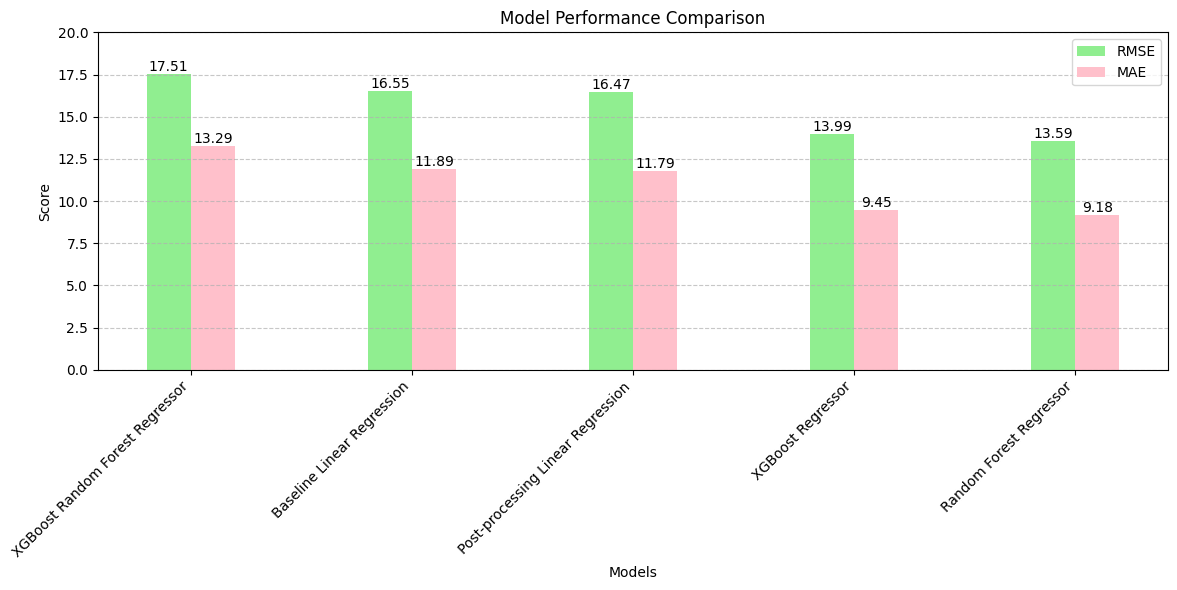

In [61]:
# Set figure size
plt.figure(figsize=(12, 6))

plt_df = full_results[["Model", "MSE", "RMSE", "MAE"]].sort_values("MSE", ascending=False)

# Create bar positions
x = range(len(plt_df))

# Create grouped bars for each metric with adjusted positions
bar_width = 0.2
bars1 = plt.bar(x, plt_df['RMSE'], bar_width, label='RMSE', color='lightgreen')
bars2 = plt.bar([i + bar_width for i in x], plt_df['MAE'], bar_width, label='MAE', color='pink')

# Add value labels on top of each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

# Customize the plot
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')

# Position x-ticks at the center of each model's bar group
plt.xticks([i + bar_width/2 for i in x], plt_df['Model'], rotation=45, ha='right')

plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 20)  # Set y-axis limit to 10% above max value

# Adjust layout to prevent label cutoff
plt.tight_layout()

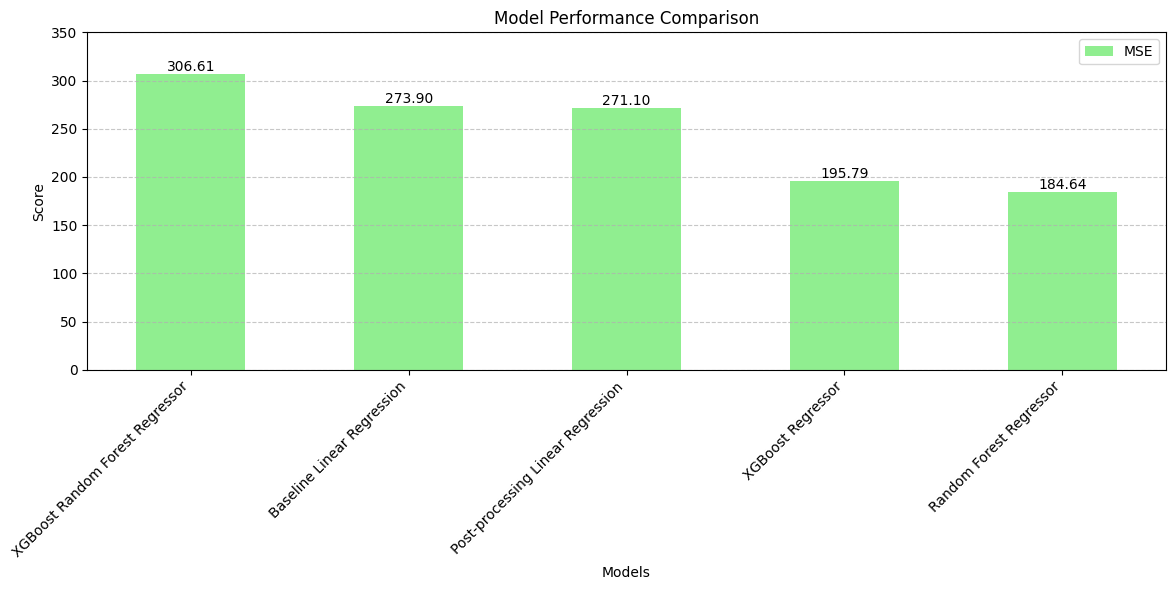

In [57]:
# Set figure size
plt.figure(figsize=(12, 6))

plt_df = full_results[["Model", "MSE", "RMSE", "MAE"]].sort_values("MSE", ascending=False)

# Create bar positions
x = range(len(plt_df))

# Create bar plot for MSE
bars = plt.bar(x, plt_df['MSE'], width=0.5, color='lightgreen', label='MSE')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Customize the plot
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')

# Center x-ticks at the bars
plt.xticks(x, plt_df['Model'], rotation=45, ha='right')

plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, 350)  # Set y-axis limit to 10% above max value

# Adjust layout to prevent label cutoff
plt.tight_layout()
